<a href="https://colab.research.google.com/github/nmermigas/GCDB/blob/main/CalendAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Imports

In [2]:
import torch
import torchvision
import requests
import zipfile
import matplotlib.pyplot as plt
import copy

from pathlib import Path
from torch import nn
from torchvision import datasets,transforms

import os
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

## 1. Setting up device agnostic code

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 2. Get data

### 2.1 The GCDB dataset
- contains data from handwritten letters in Greek, both uppercase and lowercase.

In [4]:
data_path=Path('data/')
gcdb_path = data_path / 'gcdb'

if gcdb_path.is_dir():
  print(f'{gcdb_path} directory exists')
else:
  print(f"Did not find {gcdb_path} directory, creating one...")
  gcdb_path.mkdir(parents=True, exist_ok=True)

  # Download pizza, steak, sushi data
  with open(data_path / "gcdb.zip", "wb") as f:
      request = requests.get("https://github.com/nmermigas/GCDB/raw/main/gcdb.zip")
      print("Downloading gcdb data...")
      f.write(request.content)
  # Unzip pizza, steak, sushi data
  with zipfile.ZipFile(data_path / "gcdb.zip", "r") as zip_ref:
      print("Unzipping gcdb data...")
      zip_ref.extractall(gcdb_path)
!rm $data_path/gcdb.zip

Did not find data/gcdb directory, creating one...
Unzipping gcdb data...


Creating train and test datasets out of the GCDB dataset.
Seeing the structure of the folder we downloaded, the data format is the one below:

    gcdb/
      Query/
        LETT_CAP_NORM.ALPHA/
          form_1.bmp
          form_2.bmp
          ...
        LETT_CAP_NORM.BETA/
          form_1.bmp
          form_2.bmp
          ...
        LETT_CAP_SUFF.ALPHA/
          form_1.bmp
          form_2.bmp
          ...
        LETT_CAP_SUFF.BETA/
          form_1.bmp
          form_2.bmp
          ...
        LETT_SML_NORM.ALPHA/
          form_1.bmp
          form_2.bmp
          ...
        LETT_SML_NORM.BETA/
          form_1.bmp
          form_2.bmp
          ...
        LETT_SML_SUFF.ALPHA/
          form_1.bmp
          form_2.bmp
          ...
        LETT_SML_SUFF.BETA/
          form_1.bmp
          form_2.bmp
          ...











For each of the 24 letters of the greek alphabet, there are two folders for its uppercase and 2 folders for its lowercase version.

Each folder contains `bmp` images.




Our goal is to create the following structure:


    gcdb/
      train/
        ALPHA/
          form_1.bmp
          form_2.bmp
          ...
        alpha/
          form_1.bmp
          form_2.bmp
          ...
        BETA/
          form_1.bmp
          form_2.bmp
          ...
        beta/
          form_1.bmp
          form_2.bmp
          ...
        GAMMA/
          form_1.bmp
          form_2.bmp
        ...
        gamma/
          form_1.bmp
          form_2.bmp
          ...
      test/
        ALPHA/
          form_1.bmp
          form_2.bmp
          ...
        alpha/
          form_1.bmp
          form_2.bmp
          ...
        BETA/
          form_1.bmp
          form_2.bmp
          ...
        beta/
          form_1.bmp
          form_2.bmp
          ...
        GAMMA/
          form_1.bmp
          form_2.bmp
          ...
        gamma/
          form_1.bmp
          form_2.bmp
          ...
        ...



So basically, combine the NORM and the SUFF data for each letter into one and then split them into train and test folders.

We can inspect what's in our data directory by writing a small helper function to walk through each of the subdirectories and count the files present.

To do so, we'll use Python's in-built `os.walk()`




In [5]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
walk_through_dir(gcdb_path)


There are 1 directories and 0 images in 'data/gcdb'.
There are 96 directories and 0 images in 'data/gcdb/Query'.
There are 0 directories and 440 images in 'data/gcdb/Query/LETT_SML_SUFF.YPSILON'.
There are 0 directories and 456 images in 'data/gcdb/Query/LETT_SML_SUFF.DELTA'.
There are 0 directories and 452 images in 'data/gcdb/Query/LETT_CAP_NORM.RO'.
There are 0 directories and 457 images in 'data/gcdb/Query/LETT_CAP_NORM.DELTA'.
There are 0 directories and 442 images in 'data/gcdb/Query/LETT_CAP_SUFF.YPSILON'.
There are 0 directories and 453 images in 'data/gcdb/Query/LETT_SML_SUFF.ZETA'.
There are 0 directories and 449 images in 'data/gcdb/Query/LETT_SML_NORM.RO'.
There are 0 directories and 443 images in 'data/gcdb/Query/LETT_SML_NORM.NI'.
There are 0 directories and 419 images in 'data/gcdb/Query/LETT_CAP_NORM.KSI'.
There are 0 directories and 460 images in 'data/gcdb/Query/LETT_CAP_SUFF.FI'.
There are 0 directories and 458 images in 'data/gcdb/Query/LETT_SML_NORM.ZETA'.
There ar

It looks like we have 96 directories (4 directories * 24 letters) with each containing roughly 430 images.

Now let's combine the data for each letter.


In [7]:
source_dir = "data/gcdb/Query"
for root, dirs, files in os.walk(source_dir):
    for dir_name in dirs:
        letter = dir_name.split(".")[1]
        case = dir_name.split('_')[1]
        print(f'{case}.{letter}')

SML.YPSILON
SML.DELTA
CAP.RO
CAP.DELTA
CAP.YPSILON
SML.ZETA
SML.RO
SML.NI
CAP.KSI
CAP.FI
SML.ZETA
CAP.OMEGA
CAP.XI
CAP.LAMDA
SML.MI
SML.LAMDA
SML.HETA
CAP.OMEGA
CAP.KAPA
SML.IOTA
SML.XI
SML.ALPHA
CAP.OMIKRON
CAP.HETA
SML.KAPA
CAP.ALPHA
CAP.SIGMA
SML.PSI
CAP.ZETA
SML.THETA
SML.SIGMA
CAP.PSI
SML.XI
CAP.KSI
SML.TAU
CAP.THETA
SML.BETA
SML.NI
CAP.IOTA
CAP.GAMMA
CAP.SIGMA
CAP.GAMMA
CAP.EPSILON
SML.PII
CAP.NI
SML.YPSILON
SML.THETA
SML.KSI
CAP.TAU
SML.PII
CAP.EPSILON
CAP.MI
CAP.PII
CAP.IOTA
SML.HETA
CAP.PII
SML.IOTA
CAP.HETA
CAP.YPSILON
CAP.THETA
SML.OMIKRON
SML.RO
CAP.NI
CAP.MI
CAP.RO
SML.DELTA
SML.OMEGA
CAP.BETA
CAP.PSI
SML.GAMMA
SML.OMEGA
SML.KSI
SML.FI
SML.BETA
CAP.ZETA
SML.PSI
CAP.FI
SML.EPSILON
CAP.ALPHA
SML.EPSILON
SML.LAMDA
SML.MI
SML.FI
SML.ALPHA
CAP.TAU
SML.KAPA
SML.SIGMA
SML.OMIKRON
CAP.DELTA
SML.GAMMA
CAP.LAMDA
SML.TAU
CAP.KAPA
CAP.XI
CAP.OMIKRON
CAP.BETA


In [8]:
gcdb_path_full = gcdb_path / 'Query'
gcdb_path_full

PosixPath('data/gcdb/Query')

Creating the train test directories

In [9]:
# Setup train and testing paths
train_dir = gcdb_path / "train"
test_dir =  gcdb_path / "test"

train_dir, test_dir

train_dir.mkdir(parents=True, exist_ok=True)
test_dir.mkdir(parents=True, exist_ok=True)

In [10]:
image_path_list = list(gcdb_path.glob("*/*/*.bmp"))
len(image_path_list)

42931

In [11]:
import cv2
import numpy as np

image_path_list = list(gcdb_path.glob("*/*/*.bmp"))
num_samples = len(image_path_list)  # Number of samples in your dataset

mean = np.zeros(3)
std = np.zeros(3)

for image_path in image_path_list[:1]:
    # Load the image using OpenCV
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    print(image.shape)

    # Compute mean and std for each channel
    mean += np.mean(image, axis=(0, 1))  # Compute mean across height, width, and channels
    std += np.std(image, axis=(0, 1))  # Compute std across height, width, and channels

mean /= num_samples  # Compute mean over all samples
std /= num_samples  # Compute std over all samples

print("Mean:", mean)
print("Std:", std)


(48, 41, 3)
Mean: [0.00556249 0.00556249 0.00556249]
Std: [0.00144864 0.00144864 0.00144864]


In [12]:
str(image_path_list[1])


'data/gcdb/Query/LETT_SML_SUFF.YPSILON/form_154.bmp'

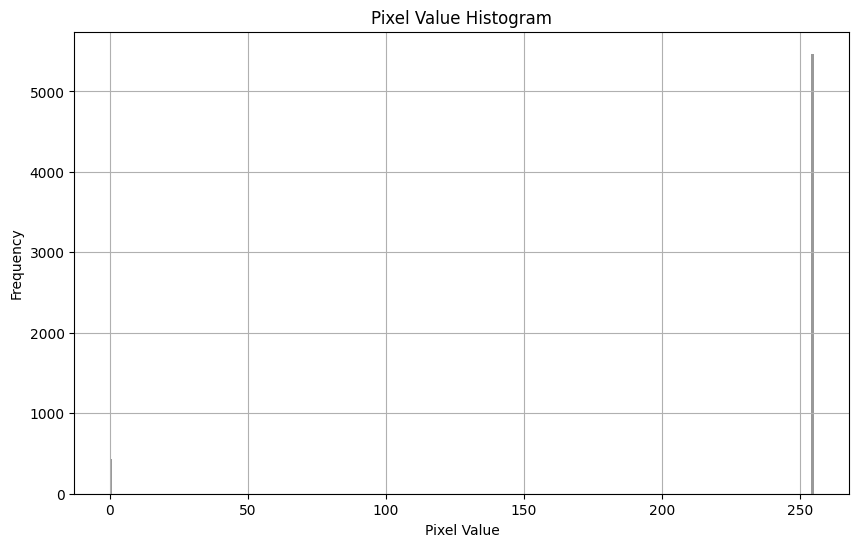

In [13]:
import cv2
import matplotlib.pyplot as plt

# Load the image
image_path = str(image_path_list[256])  # Replace with the path to your image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Flatten the image to a 1D array
pixel_values = image.flatten()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(pixel_values, bins=256, color='gray', alpha=0.8)
plt.title('Pixel Value Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [14]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Load the image using PIL (Python Imaging Library)
image = Image.open(str(image_path_list[256]))

# Define image transformations (e.g., resize, convert to tensor)
preprocess = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the image to desired dimensions
    transforms.ToTensor(),               # Convert the image to a PyTorch tensor
])

# Apply the transformations to the image
input_image = preprocess(image)

# Assuming input_image is your tensor with shape (1, 128, 128)
input_image = input_image.unsqueeze(0)  # Add a batch dimension
# input_image = input_image.unsqueeze(0)  # Add a channel dimension

# Check the shape of the input image tensor after adding the channel dimension
print("Input image shape:", input_image.shape)

# Check the shape of the input image tensor
print("Input image shape:", input_image.shape)


Input image shape: torch.Size([1, 1, 128, 128])
Input image shape: torch.Size([1, 1, 128, 128])


In [ ]:
import os
import shutil
import random

# Define source and target directories
source_dir = "data/gcdb/Query"
train_dir = "data/gcdb/train"
test_dir = "data/gcdb/test"

train_percentage = 0.8

for root, dirs, files in os.walk(source_dir):
  print(dirs)
  for dir in dirs:
    # print(f"\nAccessing directory: {dir}")

    target_train_dir = os.path.join(train_dir,dir)
    os.makedirs(target_train_dir, exist_ok=True)
    target_test_dir = os.path.join(test_dir,dir)
    os.makedirs(target_test_dir,exist_ok=True)

    image_files = [f for f in os.listdir(os.path.join(source_dir,dir))]
    # print(f'Number of images before moving to train file: {len(image_files)}')

    num_train_images = int(len(image_files) * train_percentage)
    # print(f'Moving {num_train_images} to train file')

    train_images = random.sample(image_files, num_train_images)
    # print(num_train_images)
    for img in train_images:
      img_path = os.path.join(source_dir,dir,img)
      img_train_path = os.path.join(train_dir,dir,img)
      # print(img_path)
      # print(os.path.join(train_dir,dir,img))
      shutil.move(img_path, img_train_path)
    image_files_after = [f for f in os.listdir(os.path.join(source_dir,dir))]
    # print(f'Number of images after moving to train file: {len(image_files_after)}')
    for img in image_files_after:
      img_path = os.path.join(source_dir,dir,img)
      img_test_path = os.path.join(test_dir,dir,img)
      # print(img_path)
      # print(os.path.join(train_dir,dir,img))
      shutil.move(img_path, img_test_path)
    # print(f'Number of images after the split: {len([f for f in os.listdir(os.path.join(source_dir,dir))])}')


### 2.2 Visualizing a random image

SML KSI


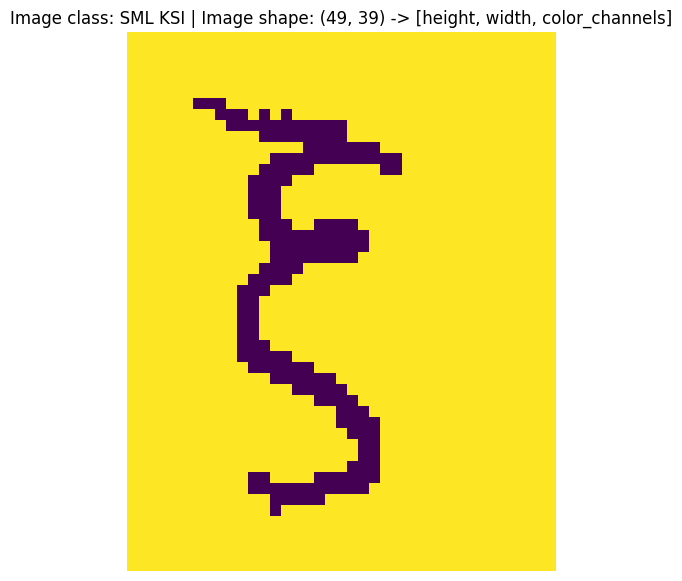

In [132]:
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


# random.seed(42)

image_path_list = list(gcdb_path.glob("*/*/*.bmp"))
# len(image_path_list)
# print(image_path_list[:10])

random_image_path = random.choice(image_path_list)
# print(str(random_image_path))
# print(str(random_image_path).split('_')[1])
# print(str(random_image_path).split('.')[1].split(('/'))[0])

image_label = f'{str(random_image_path).split("_")[1]} {str(random_image_path).split(".")[1].split("/")[0]}'
print(image_label)

img = Image.open(random_image_path)

# print(f"Random image path: {random_image_path}")
# print(f"Image class: {image_label}")
# print(f"Image height: {img.height}")
# print(f"Image width: {img.width}")
# img

img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_label} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);
# print(str(random_image_path).split('_')[1] + str(random_image_path).split('.')[0] )

In [ ]:
import os
import shutil
import random

# Define source and target directories
source_dir = "data/gcdb/Query"
train_dir = "data/gcdb/train"
test_dir = "data/gcdb/test"

train_percentage = 0.8

for root, dirs, files in os.walk(source_dir):
  print(dirs)
  for dir in dirs:
    print(f"\nAccessing directory: {dir}")

    target_train_dir = os.path.join(train_dir,dir)
    os.makedirs(target_train_dir, exist_ok=True)
    target_test_dir = os.path.join(test_dir,dir)
    os.makedirs(target_test_dir,exist_ok=True)

    image_files = [f for f in os.listdir(os.path.join(source_dir,dir))]
    # print(f'Number of images before moving to train file: {len(image_files)}')

    num_train_images = int(len(image_files) * train_percentage)
    # print(f'Moving {num_train_images} to train file')

    train_images = random.sample(image_files, num_train_images)
    # print(num_train_images)
    for img in train_images:
      img_path = os.path.join(source_dir,dir,img)
      img_train_path = os.path.join(train_dir,dir,img)
      # print(img_path)
      # print(os.path.join(train_dir,dir,img))
      shutil.move(img_path, img_train_path)
    image_files_after = [f for f in os.listdir(os.path.join(source_dir,dir))]
    # print(f'Number of images after moving to train file: {len(image_files_after)}')
    for img in image_files_after:
      img_path = os.path.join(source_dir,dir,img)
      img_test_path = os.path.join(test_dir,dir,img)
      # print(img_path)
      # print(os.path.join(train_dir,dir,img))
      shutil.move(img_path, img_test_path)
    # print(f'Number of images after the split: {len([f for f in os.listdir(os.path.join(source_dir,dir))])}')

## 3. Transforming data

1. Turn the images into tensors.
2. Turn them into a `Dataset` and then into a `DataLoader`

In [133]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    # transforms.Grayscale(),
    # Flip the images randomly on the horizontal
    # transforms.RandomHorizontalFlip(p=0.3), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor(), # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
    # transforms.Normalize(mean,std)
])

### 3.1 Creating DataLoaders.

First we need to create the ImageFolders.

In [134]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 34301
    Root location: data/gcdb/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 8630
    Root location: data/gcdb/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )


In [135]:
# Get class names as a list
class_names = train_data.classes
# class_names

In [136]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
# class_dict

In [137]:
# Check the lengths
len(train_data), len(test_data)

(34301, 8630)

In [138]:
# train_data[15][0]
len(train_data[0][0])

3

In [139]:
mean,std

(array([0.00556249, 0.00556249, 0.00556249]),
 array([0.00144864, 0.00144864, 0.00144864]))

In [141]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
Image shape: torch.Size([3, 64, 64])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


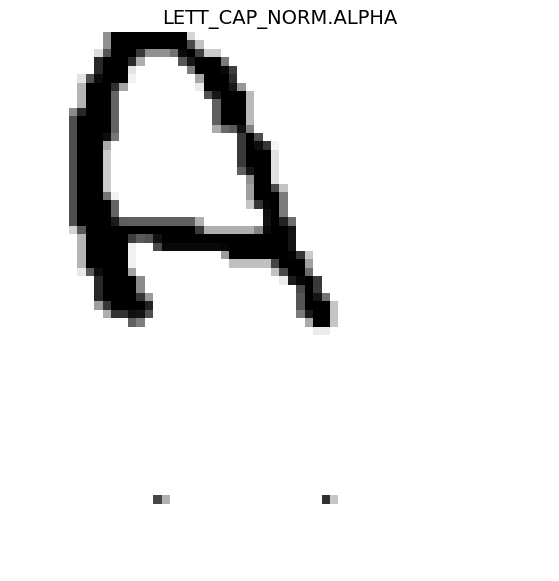

In [142]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

Then, the dataloaders

In [143]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32, # how many samples per batch?
                              num_workers=os.cpu_count(), # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             num_workers=os.cpu_count(),
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ad2024c7700>,
 <torch.utils.data.dataloader.DataLoader at 0x7ad2024c4dc0>)

In [144]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")
print(f"Label {label}")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])
Label tensor([26,  4, 79, 55, 33, 59, 41, 58,  1, 75, 22, 70, 53, 95,  1, 69, 53, 92,
        41, 17, 93, 66, 93, 26, 28,  0, 17,  9, 20, 57, 40, 77])


In [145]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

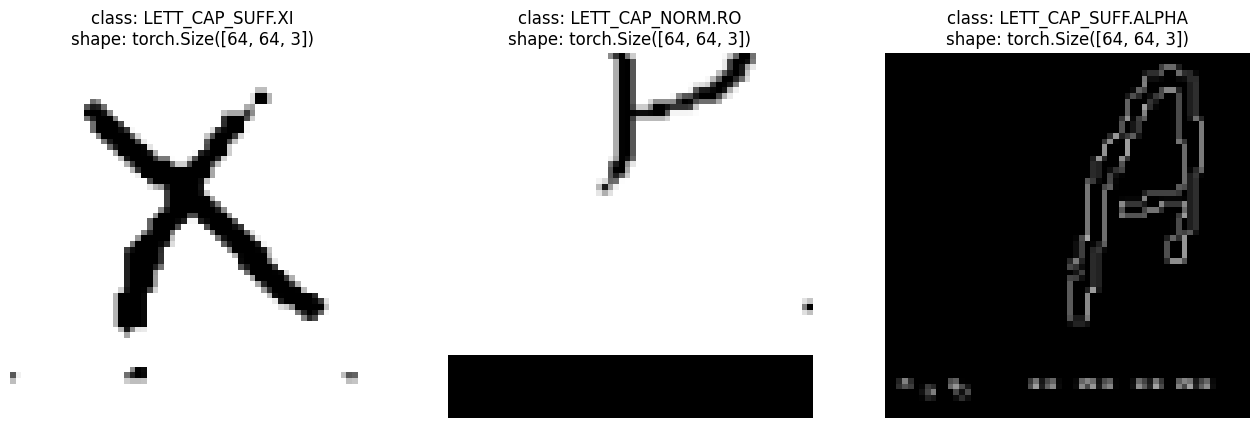

In [149]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n=3,
                      classes=class_names,
                      seed=None)

In [150]:
len(train_dataloader), len(test_dataloader)
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 4. Time to build the model. We are going to build the TinyVGG CNN based model.
https://poloclub.github.io/cnn-explainer/

In [156]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,  # Corrected output channels
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,  # Use hidden_units as input channels
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units *16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x


In [157]:
torch.manual_seed(42)
model= CNN(input_shape=3,
    hidden_units=10,
    output_shape=len(class_names)).to(device)
model

CNN(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=96, bias=True)
  )
)

Lets create some toy data to see how they "flow" through the model.

In [ ]:
torch.manual_seed(42)

# Create sample batch of random numbers with same size as image batch
images = torch.randn(size=(32, 3, 128, 128)) # [batch_size, color_channels, height, width]
test_image = images[0] # get a single image for testing
print(f"Image batch shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_image.shape} -> [color_channels, height, width]")
print(f"Single image pixel values:\n{test_image}")

In [ ]:
torch.manual_seed(42)

# Create a convolutional layer with same dimensions as TinyVGG
# (try changing any of the parameters and see what happens)
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=96,
                       kernel_size=3,
                       stride=1,
                       padding=0) # also try using "valid" or "same" here

# Pass the data through the convolutional layer
conv_layer(test_image) # Note: If running PyTorch <1.11.0, this will error because of shape issues (nn.Conv.2d() expects a 4d tensor as input)

In [108]:
# Add extra dimension to test image
test_image.unsqueeze(dim=0).shape
# Pass test image with extra dimension through conv_layer
conv_layer(test_image.unsqueeze(dim=0)).shape

torch.Size([1, 96, 126, 126])

In [109]:
torch.manual_seed(42)
# Create a new conv_layer with different values (try setting these to whatever you like)
conv_layer_2 = nn.Conv2d(in_channels=3, # same number of color channels as our input image
                         out_channels=10,
                         kernel_size=(5, 5), # kernel is usually a square so a tuple also works
                         stride=2,
                         padding=0)

# Pass single image through new conv_layer_2 (this calls nn.Conv2d()'s forward() method on the input)
conv_layer_2(test_image.unsqueeze(dim=0)).shape

torch.Size([1, 10, 62, 62])

In [110]:
# Check out the conv_layer_2 internal parameters
# print(conv_layer_2.state_dict())
# Get shapes of weight and bias tensors within conv_layer_2
print(f"conv_layer_2 weight shape: \n{conv_layer_2.weight.shape} -> [out_channels=10, in_channels=3, kernel_size=5, kernel_size=5]")
print(f"\nconv_layer_2 bias shape: \n{conv_layer_2.bias.shape} -> [out_channels=10]")

conv_layer_2 weight shape: 
torch.Size([10, 3, 5, 5]) -> [out_channels=10, in_channels=3, kernel_size=5, kernel_size=5]

conv_layer_2 bias shape: 
torch.Size([10]) -> [out_channels=10]


## 4.2 Setup loss function and optimizer for the model.

In [119]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [154]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                             lr=0.2)

## 4.3 Let's train the model.

In [124]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [113]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [158]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
from torchmetrics import Accuracy
from tqdm.auto import tqdm


train_time_start_model= timer()

# Train and test model
epochs = 5
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model = timer()
total_train_time_model = print_train_time(start=train_time_start_model,
                                           end=train_time_end_model,
                                           device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 4.56527 | Train accuracy: 1.04%
Test loss: 4.56527 | Test accuracy: 1.03%

Epoch: 1
---------
Train loss: 4.56528 | Train accuracy: 1.04%
Test loss: 4.56528 | Test accuracy: 1.03%

Epoch: 2
---------
Train loss: 4.56527 | Train accuracy: 1.04%
Test loss: 4.56531 | Test accuracy: 1.03%

Epoch: 3
---------
Train loss: 4.56526 | Train accuracy: 1.04%
Test loss: 4.56522 | Test accuracy: 1.03%

Epoch: 4
---------
Train loss: 4.56527 | Train accuracy: 1.04%
Test loss: 4.56532 | Test accuracy: 1.03%

Train time on cuda: 164.043 seconds


In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision
import copy

from torch import nn
from torchvision import datasets,transforms
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"
device

data_dir = Path('data')

# emnist_train_transforms = transforms.Compose([
#     transforms.ToTensor(),  # Convert image to tensor
#     transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to [-1, 1]
# ])

# Get EMNIST training data
emnist_data = datasets.EMNIST(root=data_dir,
                                       split='letters',
                                       train= True,
                                       download = True)

# emnist_test_data = datasets.EMNIST(root=data_dir,
#                                    split='balanced',
#                                    train=False,
#                                    download=True)


  4%|▎         | 20414464/561753746 [00:01<00:51, 10552754.30it/s]


KeyboardInterrupt: 

In [ ]:
print(f'Data size: {emnist_data.data.shape}')

images = emnist_data.data.view([emnist_data.data.shape[0],1,emnist_data.data.shape[1],emnist_data.data.shape[2]]).float()

print(f'Tensor data: {images.shape}')

Data size: torch.Size([124800, 28, 28])
Tensor data: torch.Size([124800, 1, 28, 28])


In [ ]:
emnist_data.class_to_idx

{'N/A': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [ ]:
letterCategories = emnist_data.classes[1:]
labels = copy.deepcopy(emnist_data.targets)-1
print(labels.shape)

torch.Size([124800])


In [ ]:
labels.unique()

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])

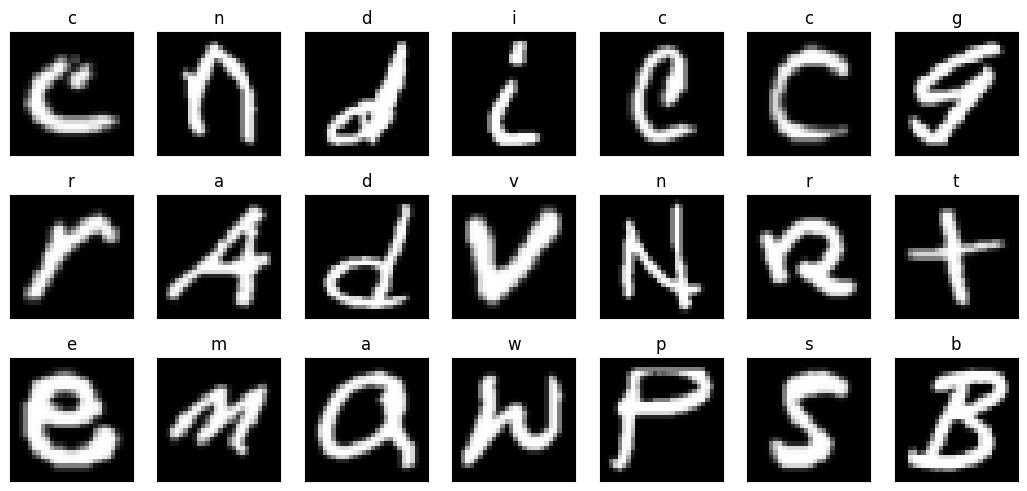

In [ ]:
# visualize

fig, axs = plt.subplots(3,7, figsize=(13,6))

for i, ax in enumerate(axs.flatten()):
  pic = np.random.randint(images.shape[0])

  image = np.squeeze(images[pic,:,:])
  letter = letterCategories[labels[pic]]

  ax.imshow(image.T,cmap='gray')
  ax.set_title(f"{letter}")
  ax.set_xticks([])
  ax.set_yticks([])
plt.show()

### Create train/test sets

In [ ]:
import os
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

num_workers = os.cpu_count()
print(num_workers)

train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=.1)

train_data = TensorDataset(train_data,train_labels)
train_data = TensorDataset(test_data,test_labels)

batch_size = 32
train_dataloader = DataLoader(train_data,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=num_workers,
                              pin_memory=True)
test_dataloader = DataLoader(test_data,
                              batch_size=batch_size,
                              shuffle=False,
                              num_workers=num_workers,
                              pin_memory=True)


2


In [ ]:
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7cce096f5930>,
 <torch.utils.data.dataloader.DataLoader at 0x7cce096f5900>)

In [ ]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 1, 28, 28]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [ ]:
print(train_dataloader.dataset.tensors[0].shape)
print(train_dataloader.dataset.tensors[1].shape)


torch.Size([12480, 1, 28, 28])
torch.Size([12480])


In [ ]:
uppercase_letters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
lowercase_letters = "abcdefghijklmnopqrstuvwxyz"

# Iterate through the directories
for letter in uppercase_letters + lowercase_letters:
  print(letter)

A
B
C
D
E
F
G
H
I
J
K
L
M
N
O
P
Q
R
S
T
U
V
W
X
Y
Z
a
b
c
d
e
f
g
h
i
j
k
l
m
n
o
p
q
r
s
t
u
v
w
x
y
z
